# MTA Project MVP

## Key Summay of Findings
1. View data set
2. delete duplicates
3. deal with reverse counter
4. get top 20 station list in popularity and filter down the data

## Key Summay of Next Steps
1. look at the MTA map and delete station candidate that does not meet the standard
2. Analyze data to see which station/timeslot is best for the singer to hold a live concert

### Step 1
- Download MTA turnstile data files for the following dates: ```210703-211002```

- Load the files into a pandas DataFrame (hint: `pd.read_csv()` to load files and `pd.concat()` to combine DataFrames)


In [1]:
import pandas as pd
import numpy as np

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [210703, 210710, 210717, 210724, 210731, 210807, 210814, 210821, 210828, 210904, 210911, 210918, 210925, 211002]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2934629 entries, 0 to 210210
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), obj

In [4]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [5]:
# Three months of Data
turnstiles_df.DATE.value_counts().sort_index().head(10)

06/26/2021    29965
06/27/2021    29840
06/28/2021    29814
06/29/2021    29843
06/30/2021    29883
07/01/2021    30107
07/02/2021    30378
07/03/2021    30114
07/04/2021    29839
07/05/2021    29855
Name: DATE, dtype: int64

In [6]:
turnstiles_df.STATION.unique().shape

(379,)

there are 379 unique station

### Step 2

- turn this into a time series.

- Convert into datatime object.

In [7]:
import datetime
# from datetime import datetime as dt

In [8]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [9]:
# Keep only data from 2021-06-30 to 2021-09-30
turnstiles_df=turnstiles_df.loc[(turnstiles_df["DATE_TIME"].dt.date)>=(datetime.datetime(2021, 6, 30).date())]
turnstiles_df=turnstiles_df.loc[(turnstiles_df["DATE_TIME"].dt.date)<=(datetime.datetime(2021, 9, 30).date())]

In [10]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
24,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/30/2021,00:00:00,REGULAR,7594634,2596427,2021-06-30 00:00:00
25,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/30/2021,04:00:00,REGULAR,7594636,2596427,2021-06-30 04:00:00
26,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/30/2021,08:00:00,REGULAR,7594648,2596489,2021-06-30 08:00:00
27,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/30/2021,12:00:00,REGULAR,7594709,2596622,2021-06-30 12:00:00
28,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/30/2021,16:00:00,REGULAR,7594865,2596654,2021-06-30 16:00:00


### Interlude: Duplicate Entries
Now let's run some diagnostics on the data and see approaches to cleaning before tackling next steps

In [11]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2763279,S101,R070,00-00-02,ST. GEORGE,2021-09-13 16:00:00,2
2763362,S101,R070,00-00-02,ST. GEORGE,2021-09-27 12:00:00,2
2763216,S101,R070,00-00-02,ST. GEORGE,2021-09-03 12:00:00,2
2763215,S101,R070,00-00-02,ST. GEORGE,2021-09-03 08:00:00,2
2763213,S101,R070,00-00-02,ST. GEORGE,2021-09-03 00:00:00,2


Looks like there are several turnstiles that have duplicate recordings. Group by turnstile(not by date) to find out how many unique turnstiles are there.

* Since we are interested in Entries, we want to know what happened.

In [12]:
# Get rid of the duplicate entry, keep only recover audit if duplicate
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME","DESC"], 
                          inplace=True, ascending=[False,False,False,False,False,True])
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [13]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-06-30 00:00:00,1
1856755,R139,R031,04-00-01,34 ST-PENN STA,2021-09-20 00:00:00,1
1856747,R139,R031,04-00-01,34 ST-PENN STA,2021-09-18 16:00:00,1
1856748,R139,R031,04-00-01,34 ST-PENN STA,2021-09-18 20:00:00,1
1856749,R139,R031,04-00-01,34 ST-PENN STA,2021-09-19 00:00:00,1


* No more duplicate Entries

In [14]:
# Drop Exits, Desc Column. To prevent errors in multiple run of cell, errors on drop is ignored
turnstiles_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

### Step 3 Preliminary EDA
- Each combination of `C/A`, `UNIT`, `SCP`, and `STATION` represents a unique turnstile. Obtain the maximum `ENTRIES` value for each day, for each unique turnstile.

The maximum `ENTRIES` value would occur at the last reading of the day. Since rows are listed in descending order of time, we can grab the last reading of the day (located at the top of the group) using the `.first()` DataFrame method.

In [23]:
turnstiles_df.tail(40)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,DATE_TIME
21,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2021,12:00:00,7597627,2021-07-06 12:00:00
20,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2021,08:00:00,7597571,2021-07-06 08:00:00
19,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2021,04:00:00,7597555,2021-07-06 04:00:00
18,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/06/2021,00:00:00,7597548,2021-07-06 00:00:00
17,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,20:00:00,7597477,2021-07-05 20:00:00
16,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,16:00:00,7597348,2021-07-05 16:00:00
15,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,12:00:00,7597226,2021-07-05 12:00:00
14,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,08:00:00,7597180,2021-07-05 08:00:00
13,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,04:00:00,7597173,2021-07-05 04:00:00
12,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/05/2021,00:00:00,7597165,2021-07-05 00:00:00


In [19]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME","DATE"],as_index=False)
                        .ENTRIES.first())

In [25]:
check1=turnstiles_daily[(turnstiles_daily["C/A"]=="A002")&(turnstiles_daily["UNIT"]=="R051")&(turnstiles_daily["SCP"]=="02-00-00")&(turnstiles_daily["STATION"]=="59 ST")]
check1.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,06/30/2021,7595154
1,A002,R051,02-00-00,59 ST,NQR456W,07/01/2021,7595703
2,A002,R051,02-00-00,59 ST,NQR456W,07/02/2021,7596330
3,A002,R051,02-00-00,59 ST,NQR456W,07/03/2021,7596715
4,A002,R051,02-00-00,59 ST,NQR456W,07/04/2021,7597078


In [26]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,06/30/2021,7595154
1,A002,R051,02-00-00,59 ST,NQR456W,07/01/2021,7595703
2,A002,R051,02-00-00,59 ST,NQR456W,07/02/2021,7596330
3,A002,R051,02-00-00,59 ST,NQR456W,07/03/2021,7596715
4,A002,R051,02-00-00,59 ST,NQR456W,07/04/2021,7597078


- The `ENTRIES` column contains 
**cumulative entries** on each day. Now to calculate **daily entries**, i.e. the number of new entries gained each day.

In [27]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION","LINENAME"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [28]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,NQR456W,06/30/2021,7595154,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,07/01/2021,7595703,06/30/2021,7595154.0
2,A002,R051,02-00-00,59 ST,NQR456W,07/02/2021,7596330,07/01/2021,7595703.0
3,A002,R051,02-00-00,59 ST,NQR456W,07/03/2021,7596715,07/02/2021,7596330.0
4,A002,R051,02-00-00,59 ST,NQR456W,07/04/2021,7597078,07/03/2021,7596715.0


In [29]:
# Drop the rows for the earliest date in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

### Interlude: Reverse Entries

Next, let's look at some more weirdness in the data and think about handling it before we finalize our daily count column

In [31]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
3628,A011,R080,01-03-00,57 ST-7 AV,NQRW,07/01/2021,885593780,06/30/2021,885594053.0
3629,A011,R080,01-03-00,57 ST-7 AV,NQRW,07/02/2021,885593507,07/01/2021,885593780.0
3630,A011,R080,01-03-00,57 ST-7 AV,NQRW,07/03/2021,885593287,07/02/2021,885593507.0
3631,A011,R080,01-03-00,57 ST-7 AV,NQRW,07/04/2021,885593112,07/03/2021,885593287.0
3632,A011,R080,01-03-00,57 ST-7 AV,NQRW,07/05/2021,885592916,07/04/2021,885593112.0


In [32]:
# Let's see how many stations have this problem

(turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A011   R080  01-03-00  57 ST-7 AV         92
A013   R081  01-06-01  49 ST               1
A014   R081  02-00-00  49 ST               1
A049   R088  02-05-00  CORTLANDT ST       23
A066   R118  00-00-00  CANAL ST           92
A084   R125  01-03-02  BROAD ST            1
B021   R228  00-05-00  AVENUE J            1
B025   R150  00-00-01  AVENUE U            1
C008   R099  00-00-00  DEKALB AV          92
C025   R215  00-00-00  86 ST               1
D011   R394  01-06-00  BAY PKWY           92
             01-06-01  BAY PKWY           92
G009   R151  02-00-00  CONEY IS-STILLW     1
G015   R312  01-05-00  W 8 ST-AQUARIUM     1
H003   R163  01-00-02  6 AV               92
H012   R268  01-00-00  LORIMER ST          1
             01-00-01  LORIMER ST          1
H023   R236  00-00-01  DEKALB AV          92
             00-06-00  DEKALB AV          92
H026   R137  00-03-00  MYRTLE-WYCKOFF      1
             00-03-01  MYRTLE-WYCKOFF      1
             00-

In [33]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=100000)

393216 1.0
5 150038.0
353 8049630.0
12 468610.0
167790157 702266.0
58 317664.0
63 9631506.0
310 5609562.0
351 132517.0
35 9768753.0
33565227 188178.0
48 8724126.0
458768 2578.0
65 106396.0
2230264 957017.0
957373 2230264.0
1064 150473.0
393216 728.0
511 3272795.0
284 124319.0
5946 4298704.0
0 117440512.0
83 366981.0
331 500527.0
1966428 196464.0
327975 7577027.0
67109632 14.0
327682 67109640.0
15 67109632.0
36 1198448.0
103 305512.0
263 557914756.0
46 5405351.0
200 705357551.0
16777220 1037157.0
6 16034831.0
974 197582.0
458814 271001.0
327682 786526.0
327680 0.0
386 6213955.0
442 656520.0
37 1950780.0
443 15689395.0
772 239100.0
261 120093.0
609994 1021.0
1606 609994.0
157 129729.0
12666 341621.0
1193 117404.0
458 182438.0
220 624575.0
7329 430115.0
134 226543.0
108 277764.0
500 118845.0
2 146227.0
316 319276.0
8 1255797.0
21 120055.0
240 993695.0
7 201369.0
138 380611.0
5 11123659.0
256 3153907.0
126 3102523.0
403 315741.0
389 509445.0
0 458872.0
360 408702.0
178 164477.0
19 2570919.

In [ ]:






40 118770.0
114 1953573.0
43 3154069.0
1891101745 1104755.0
5 11123659.0
11123659 4624026.0


In [34]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,NQR456W,07/01/2021,7595703,06/30/2021,7595154.0,549.0
2,A002,R051,02-00-00,59 ST,NQR456W,07/02/2021,7596330,07/01/2021,7595703.0,627.0
3,A002,R051,02-00-00,59 ST,NQR456W,07/03/2021,7596715,07/02/2021,7596330.0,385.0
4,A002,R051,02-00-00,59 ST,NQR456W,07/04/2021,7597078,07/03/2021,7596715.0,363.0
5,A002,R051,02-00-00,59 ST,NQR456W,07/05/2021,7597477,07/04/2021,7597078.0,399.0


### From 3 regions, each select 5 stations that has the top traffic
- Downtown NYC: FULTON ST/ 14 ST-UNION SQ/ CANAL ST/ 14 ST/ W 4 ST-WASH SQ  
- Garment District+Murray Hill+Kips Bay: 34 ST-PENN STA/ 34 ST-HERALD SQ/ GRD CNTRL-42 ST/ 23 ST/ TIMES SQ-42 ST  
- Long Island City: QUEENSBORO PLZ/ VERNON-JACKSON/ COURT SQ/ QUEENS PLAZA/ COURT SQ-23 ST

Filter the data so that only these stations will be analyzed and compared

In [35]:
def is_cand (station):
    candidate_stations=["FULTON ST","14 ST-UNION SQ","CANAL ST","14 ST","W 4 ST-WASH SQ",
                       "34 ST-PENN STA","34 ST-HERALD SQ","GRD CNTRL-42 ST","23 ST","TIMES SQ-42 ST",
                       "QUEENSBORO PLZ","VERNON-JACKSON","COURT SQ","QUEENS PLAZA","COURT SQ-23 ST"]
    if station in candidate_stations:
        return 1
    return 0

In [36]:
turnstiles_daily["IS_CAND"]=turnstiles_daily.STATION.apply(is_cand)

In [37]:
candstation_daily=turnstiles_daily[turnstiles_daily.IS_CAND==1]
candstation_daily.reset_index(inplace=True)
candstation_daily.STATION.unique()

array(['TIMES SQ-42 ST', '34 ST-HERALD SQ', '23 ST', '14 ST-UNION SQ',
       'CANAL ST', 'FULTON ST', '34 ST-PENN STA', '14 ST',
       'W 4 ST-WASH SQ', 'COURT SQ-23 ST', 'QUEENS PLAZA', 'COURT SQ',
       'GRD CNTRL-42 ST', 'VERNON-JACKSON', 'QUEENSBORO PLZ'], dtype=object)

Check if 15 stations are filtered correctly

In [39]:
candstation_total=candstation_daily.groupby("STATION").DAILY_ENTRIES.sum().reset_index()
candstation_total=candstation_total.sort_values("DAILY_ENTRIES",ascending=False).reset_index().drop("index",axis=1)

In [40]:
candstation_total

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,4209281.0
1,34 ST-HERALD SQ,3162092.0
2,GRD CNTRL-42 ST,2971456.0
3,23 ST,2727017.0
4,14 ST-UNION SQ,2619891.0
5,TIMES SQ-42 ST,2363708.0
6,FULTON ST,2259132.0
7,CANAL ST,1973646.0
8,14 ST,1616290.0
9,W 4 ST-WASH SQ,1157761.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

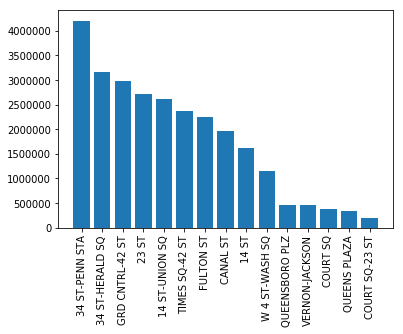

In [42]:
import matplotlib.pyplot as plt
plt.bar(candstation_total.STATION,candstation_total.DAILY_ENTRIES)
plt.xticks(rotation=90)

two example online: 47-50 Sts-Rockefeller Ctr('47-50 STS ROCK') / Grand Central('GRD CNTRL-42 ST')

Check their entries sum

In [43]:
turnstiles_daily[turnstiles_daily.STATION=='47-50 STS ROCK'].groupby("STATION").DAILY_ENTRIES.sum()

STATION
47-50 STS ROCK    1226092.0
Name: DAILY_ENTRIES, dtype: float64

In [44]:
turnstiles_daily[turnstiles_daily.STATION=='GRD CNTRL-42 ST'].groupby("STATION").DAILY_ENTRIES.sum()

STATION
GRD CNTRL-42 ST    2971456.0
Name: DAILY_ENTRIES, dtype: float64

Thus we would want some traffic around 1.2b-3.1b for 3 month. And we have:

- GRD CNTRL-42 ST
- 23 ST
- 14 ST-UNION SQ
- TIMES SQ-42 ST
- CANAL ST
- 14 ST
- W 4 ST-WASH SQ


We want to make sure the space is broad and at least clean for a video shot, hence we manually leave out 4 stations, and here comes our top 3 pick:
    
- GRD CNTRL-42 ST
- 14 ST-UNION SQ
- TIMES SQ-42 ST

### For Top 3, select month, day of week

In [45]:
top3_daily=turnstiles_daily[(turnstiles_daily.STATION=='GRD CNTRL-42 ST')|(turnstiles_daily.STATION=='14 ST-UNION SQ')|(turnstiles_daily.STATION=='TIMES SQ-42 ST')]
top3_daily=top3_daily.reset_index().drop("index",axis=1)

In [46]:
top3_daily.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES,IS_CAND
0,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,07/01/2021,10021418,06/30/2021,10020140.0,1278.0,1
1,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,07/02/2021,10022558,07/01/2021,10021418.0,1140.0,1
2,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,07/03/2021,10023158,07/02/2021,10022558.0,600.0,1
3,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,07/04/2021,10023676,07/03/2021,10023158.0,518.0,1
4,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,07/05/2021,10024253,07/04/2021,10023676.0,577.0,1


In [47]:
top3_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16108 entries, 0 to 16107
Data columns (total 11 columns):
C/A              16108 non-null object
UNIT             16108 non-null object
SCP              16108 non-null object
STATION          16108 non-null object
LINENAME         16108 non-null object
DATE             16108 non-null object
ENTRIES          16108 non-null int64
PREV_DATE        16108 non-null object
PREV_ENTRIES     16108 non-null float64
DAILY_ENTRIES    16108 non-null float64
IS_CAND          16108 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.4+ MB


In [48]:
top3_station_daily=top3_daily.groupby(["STATION","DATE"]).DAILY_ENTRIES.sum().reset_index()
top3_station_daily.DATE=pd.to_datetime(top3_station_daily.DATE)
top3_station_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 3 columns):
STATION          276 non-null object
DATE             276 non-null datetime64[ns]
DAILY_ENTRIES    276 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.5+ KB


In [80]:
top3_daily.groupby(["STATION"]).DAILY_ENTRIES.sum().reset_index()

,STATION,DAILY_ENTRIES
0,14 ST-UNION SQ,2619891.0
1,GRD CNTRL-42 ST,2971456.0
2,TIMES SQ-42 ST,2363708.0


In [81]:
top3_station_daily.groupby(["STATION"]).DAILY_ENTRIES.sum().reset_index()

,STATION,DAILY_ENTRIES
0,14 ST-UNION SQ,2619891.0
1,GRD CNTRL-42 ST,2971456.0
2,TIMES SQ-42 ST,2363708.0


In [49]:
top3_station_daily["MONTH"]=top3_station_daily.DATE.dt.month
top3_station_monthly=top3_station_daily.groupby(["STATION","MONTH"]).DAILY_ENTRIES.mean().reset_index()
top3_station_monthly

,STATION,MONTH,DAILY_ENTRIES
0,14 ST-UNION SQ,7,26738.548387
1,14 ST-UNION SQ,8,26625.451613
2,14 ST-UNION SQ,9,32186.900000
3,GRD CNTRL-42 ST,7,32045.419355
4,GRD CNTRL-42 ST,8,30647.838710
5,GRD CNTRL-42 ST,9,34265.500000
6,TIMES SQ-42 ST,7,25429.161290
7,TIMES SQ-42 ST,8,24634.129032
8,TIMES SQ-42 ST,9,27058.200000


In [50]:
top3_station_monthly_pivot=pd.pivot_table(top3_station_monthly,values="DAILY_ENTRIES",columns="STATION",index="MONTH")
top3_station_monthly_pivot

STATION,14 ST-UNION SQ,GRD CNTRL-42 ST,TIMES SQ-42 ST
MONTH,,,
7,26738.548387,32045.419355,25429.161290
8,26625.451613,30647.838710,24634.129032
9,32186.900000,34265.500000,27058.200000


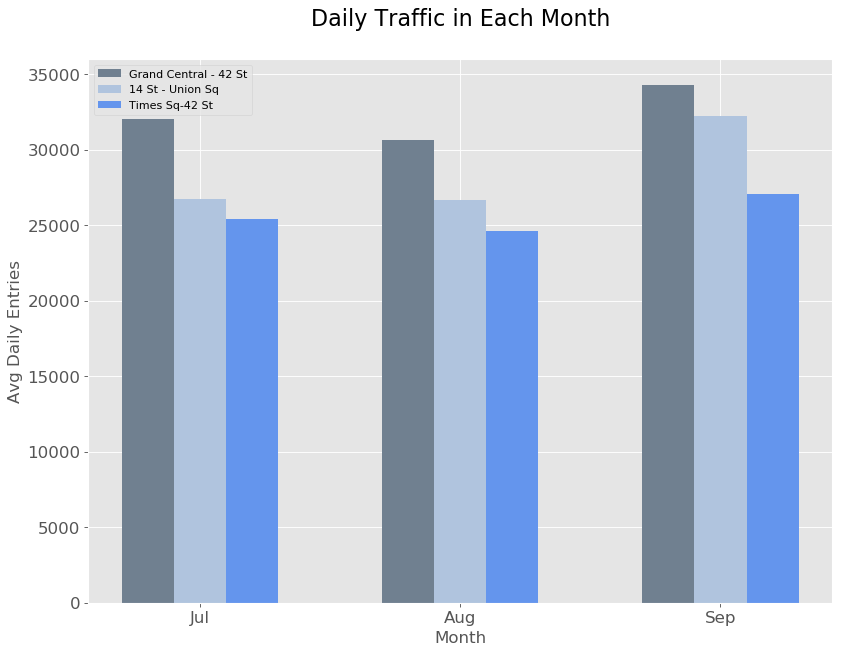

In [51]:
X = ["Jul","Aug","Sep"]  
X_axis = np.arange(len(X))
plt.style.use('ggplot')
plt.figure(figsize=(12, 9), dpi=80)
plt.bar(X_axis-0.2, top3_station_monthly_pivot["GRD CNTRL-42 ST"], 0.2,label = 'Grand Central - 42 St',color="slategrey")
plt.bar(X_axis, top3_station_monthly_pivot["14 ST-UNION SQ"], 0.2,label = '14 St - Union Sq',color="lightsteelblue")
plt.bar(X_axis + 0.2, top3_station_monthly_pivot["TIMES SQ-42 ST"], 0.2,label = 'Times Sq-42 St',color="cornflowerblue")
  
plt.xticks(X_axis, X,size=15)
plt.yticks(size=15)
plt.xlabel("Month",size=15,x=0.5)
plt.ylabel("Avg Daily Entries",size=15,x=-0.2)
plt.title("Daily Traffic in Each Month",size=20,y=1.05)
plt.legend()

plt.savefig("DailyTraffic_M.png", dpi=300, transparent=True)

We could see that September has the most traffic across 3 stations and August follows.

Next we want to see which day of week is better.

In [52]:
top3_station_daily["DAY_OF_WEEK"]=top3_station_daily.DATE.dt.dayofweek
top3_station_daily.head()

,STATION,DATE,DAILY_ENTRIES,MONTH,DAY_OF_WEEK
0,14 ST-UNION SQ,2021-07-01,27238.0,7,3
1,14 ST-UNION SQ,2021-07-02,27800.0,7,4
2,14 ST-UNION SQ,2021-07-03,22153.0,7,5
3,14 ST-UNION SQ,2021-07-04,17130.0,7,6
4,14 ST-UNION SQ,2021-07-05,19438.0,7,0


In [83]:
top3_station_daily.groupby("STATION").DAILY_ENTRIES.sum()

STATION
14 ST-UNION SQ     2619891.0
GRD CNTRL-42 ST    2971456.0
TIMES SQ-42 ST     2363708.0
Name: DAILY_ENTRIES, dtype: float64

In [53]:
top3_station_weekly=top3_station_daily.groupby(["STATION","DAY_OF_WEEK"]).DAILY_ENTRIES.mean().reset_index()
top3_station_weekly

,STATION,DAY_OF_WEEK,DAILY_ENTRIES
0,14 ST-UNION SQ,0,27718.230769
1,14 ST-UNION SQ,1,31058.769231
2,14 ST-UNION SQ,2,32869.769231
3,14 ST-UNION SQ,3,30568.928571
4,14 ST-UNION SQ,4,31754.384615
5,14 ST-UNION SQ,5,25968.538462
6,14 ST-UNION SQ,6,19240.000000
7,GRD CNTRL-42 ST,0,33370.846154
8,GRD CNTRL-42 ST,1,39561.769231
9,GRD CNTRL-42 ST,2,40328.000000


In [82]:
top3_station_weekly.groupby("STATION").DAILY_ENTRIES.sum()

STATION
14 ST-UNION SQ     199178.620879
GRD CNTRL-42 ST    225597.604396
TIMES SQ-42 ST     179687.131868
Name: DAILY_ENTRIES, dtype: float64

In [54]:
top3_station_weekly_pivot=pd.pivot_table(top3_station_weekly,values="DAILY_ENTRIES",columns="STATION",index="DAY_OF_WEEK")
top3_station_weekly_pivot

STATION,14 ST-UNION SQ,GRD CNTRL-42 ST,TIMES SQ-42 ST
DAY_OF_WEEK,,,
0,27718.230769,33370.846154,25480.076923
1,31058.769231,39561.769231,28111.923077
2,32869.769231,40328.000000,28851.846154
3,30568.928571,38687.142857,27775.285714
4,31754.384615,35959.307692,26801.076923
5,25968.538462,21165.769231,23357.076923
6,19240.000000,16524.769231,19309.846154


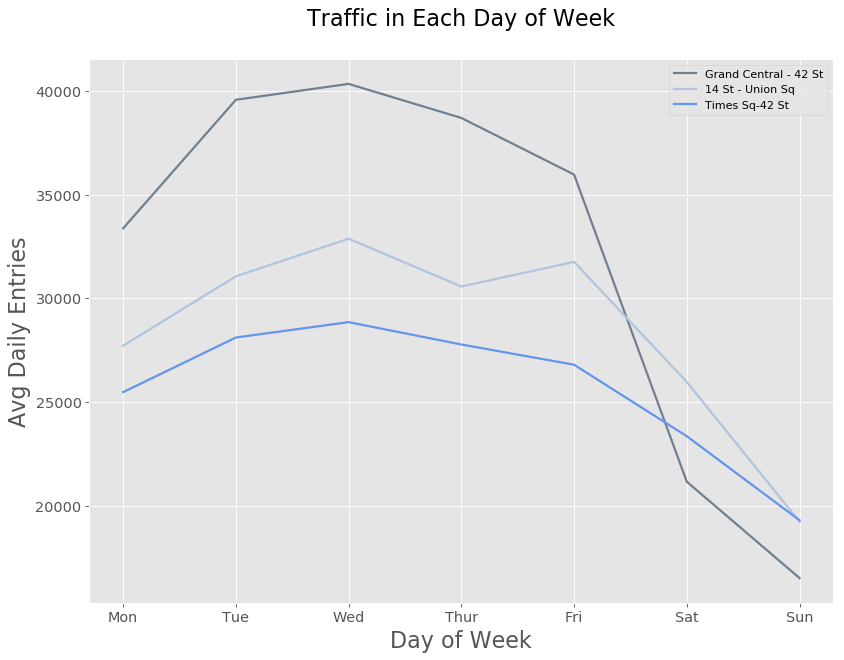

In [55]:
X = ["Mon","Tue","Wed","Thur","Fri","Sat","Sun"]  
X_axis = np.arange(len(X))
plt.style.use('ggplot')
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(X_axis, top3_station_weekly_pivot["GRD CNTRL-42 ST"],label = 'Grand Central - 42 St',color="slategrey",linewidth=2)
plt.plot(X_axis, top3_station_weekly_pivot["14 ST-UNION SQ"],label = '14 St - Union Sq',color="lightsteelblue",linewidth=2)
plt.plot(X_axis, top3_station_weekly_pivot["TIMES SQ-42 ST"],label = 'Times Sq-42 St',color="cornflowerblue",linewidth=2)
  
plt.xticks(X_axis, X,size=13)
plt.yticks(size=13)
plt.xlabel("Day of Week",size=20)
plt.ylabel("Avg Daily Entries",size=20)
plt.title("Traffic in Each Day of Week",size=20,y=1.05)
plt.legend()
plt.savefig("DailyTraffic_W.png", dpi=300, transparent=True)

### For top 3, select hours of the day
Since weekends traffic are much lower comparing with weekdays, we'll average hours across weekdays/weekends

In [114]:
turnstiles_top3_df=turnstiles_df[(turnstiles_df.STATION=='GRD CNTRL-42 ST')|(turnstiles_df.STATION=='14 ST-UNION SQ')|(turnstiles_df.STATION=='TIMES SQ-42 ST')]
turnstiles_top3_df=turnstiles_top3_df.reset_index().drop("index",axis=1)

In [115]:
def extract_hour(time):
    hour=int(time[0:2] )
    if hour in [23,0,1,2]: return 4
    elif hour in [3,4,5,6]: return 8
    elif hour in [7,8,9,10]: 
        return 12
    elif hour in [11,12,13,14]:
        return 16
    elif hour in [15,16,17,18]:
        return 20
    elif hour in [19,20,21,22]:
        return 24

def if_weekends(day_of_week):
    if ((day_of_week==5)|(day_of_week==6)):
        return 1
    return 0
    

In [116]:
turnstiles_top3_df["TIMERANGE"]=turnstiles_top3_df.TIME.apply(extract_hour)
turnstiles_top3_df.head()
turnstiles_top3_df= (turnstiles_top3_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "LINENAME","DATE","TIMERANGE"],as_index=False)
                        .ENTRIES.first())

In [117]:
turnstiles_top3_df["DATE"]=pd.to_datetime(turnstiles_top3_df["DATE"])
turnstiles_top3_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97517 entries, 0 to 97516
Data columns (total 8 columns):
C/A          97517 non-null object
UNIT         97517 non-null object
SCP          97517 non-null object
STATION      97517 non-null object
LINENAME     97517 non-null object
DATE         97517 non-null datetime64[ns]
TIMERANGE    97517 non-null int64
ENTRIES      97517 non-null int64
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 6.7+ MB


In [118]:
turnstiles_top3_df["DAY_OF_WEEK"]=turnstiles_top3_df.DATE.dt.dayofweek
turnstiles_top3_df["IF_WEEKENDS"]=turnstiles_top3_df.DAY_OF_WEEK.apply(if_weekends)

In [126]:
turnstiles_top3_df[["PREV_DATE_TIME", "PREV_ENTRIES"]] = (turnstiles_top3_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["TIMERANGE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [127]:
turnstiles_top3_df.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)
turnstiles_top3_df.head(20)

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIMERANGE,ENTRIES,DAY_OF_WEEK,IF_WEEKENDS,PREV_DATE_TIME,PREV_ENTRIES
1,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-06-30,8,10018999,2,0,4.0,10018988.0
2,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-06-30,12,10019147,2,0,8.0,10018999.0
3,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-06-30,16,10019354,2,0,12.0,10019147.0
4,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-06-30,20,10019553,2,0,16.0,10019354.0
5,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-06-30,24,10020140,2,0,20.0,10019553.0
6,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-07-01,4,10020286,3,0,24.0,10020140.0
7,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-07-01,8,10020303,3,0,4.0,10020286.0
8,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-07-01,12,10020421,3,0,8.0,10020303.0
9,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-07-01,16,10020652,3,0,12.0,10020421.0
10,A021,R032,01-00-00,TIMES SQ-42 ST,ACENQRS1237W,2021-07-01,20,10020865,3,0,16.0,10020652.0


In [128]:
def get_hourly_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_top3_df["HOURLY_ENTRIES"] = turnstiles_top3_df.apply(get_hourly_counts, axis=1, max_counter=100000)

11123659 4624026.0
5 11123659.0
1891101745 1104755.0
43 3154069.0
114 1953573.0
40 118770.0


In [129]:
turnstiles_top3_df.groupby("STATION").HOURLY_ENTRIES.sum()


STATION
14 ST-UNION SQ     2632201.0
GRD CNTRL-42 ST    2989004.0
TIMES SQ-42 ST     2373764.0
Name: HOURLY_ENTRIES, dtype: float64

## Check hourly average

In [131]:
top3_hr=turnstiles_top3_df.groupby(["STATION","DATE","TIMERANGE"]).HOURLY_ENTRIES.sum().reset_index()
top3_hr.groupby("STATION").HOURLY_ENTRIES.sum()

STATION
14 ST-UNION SQ     2632201.0
GRD CNTRL-42 ST    2989004.0
TIMES SQ-42 ST     2373764.0
Name: HOURLY_ENTRIES, dtype: float64

In [132]:
top3_hr.head()

,STATION,DATE,TIMERANGE,HOURLY_ENTRIES
0,14 ST-UNION SQ,2021-06-30,8,289.0
1,14 ST-UNION SQ,2021-06-30,12,2050.0
2,14 ST-UNION SQ,2021-06-30,16,4391.0
3,14 ST-UNION SQ,2021-06-30,20,9024.0
4,14 ST-UNION SQ,2021-06-30,24,9445.0


In [133]:
top3_hr_avg=top3_hr.groupby(["STATION","TIMERANGE"]).HOURLY_ENTRIES.mean().reset_index()
top3_hr_avg

,STATION,TIMERANGE,HOURLY_ENTRIES
0,14 ST-UNION SQ,4,3775.184783
1,14 ST-UNION SQ,8,454.118280
2,14 ST-UNION SQ,12,1800.741935
3,14 ST-UNION SQ,16,4034.462366
4,14 ST-UNION SQ,20,9276.903226
5,14 ST-UNION SQ,24,9100.271739
6,GRD CNTRL-42 ST,4,3262.760870
7,GRD CNTRL-42 ST,8,426.451613
8,GRD CNTRL-42 ST,12,2925.559140
9,GRD CNTRL-42 ST,16,6023.913978


In [134]:
top3_hr.groupby(["STATION","TIMERANGE"]).count()

DATE  HOURLY_ENTRIES
STATION         TIMERANGE                      
14 ST-UNION SQ  4            92              92
                8            93              93
                12           93              93
                16           93              93
                20           93              93
                24           92              92
GRD CNTRL-42 ST 4            92              92
                8            93              93
                12           93              93
                16           93              93
                20           93              93
                24           92              92
TIMES SQ-42 ST  4            92              92
                8            93              93
                12           93              93
                16           93              93
                20           93              93
                24           92              92

#### First look at weekdays

In [136]:
top3_turnstiles_weekdays=turnstiles_top3_df[turnstiles_top3_df.IF_WEEKENDS==0]
top3_hr_weekdays=top3_turnstiles_weekdays.groupby(["STATION","DATE","TIMERANGE"]).HOURLY_ENTRIES.sum().reset_index()

top3_hr_weekdays.head()

,STATION,DATE,TIMERANGE,HOURLY_ENTRIES
0,14 ST-UNION SQ,2021-06-30,8,289.0
1,14 ST-UNION SQ,2021-06-30,12,2050.0
2,14 ST-UNION SQ,2021-06-30,16,4391.0
3,14 ST-UNION SQ,2021-06-30,20,9024.0
4,14 ST-UNION SQ,2021-06-30,24,9445.0


In [137]:
top3_TR_weekdays=top3_hr_weekdays.groupby(["STATION","TIMERANGE"]).HOURLY_ENTRIES.mean().reset_index()

In [138]:
top3_TR_weekdays_pivot=pd.pivot_table(top3_TR_weekdays,values="HOURLY_ENTRIES",columns="STATION",index="TIMERANGE")
top3_TR_weekdays_pivot

STATION,14 ST-UNION SQ,GRD CNTRL-42 ST,TIMES SQ-42 ST
TIMERANGE,,,
4,3558.363636,3228.242424,4440.924242
8,295.746269,375.776119,801.567164
12,2190.985075,3784.910448,2008.417910
16,4398.432836,6958.641791,4074.880597
20,10175.074627,10005.029851,5914.776119
24,10095.348485,13191.378788,10125.075758


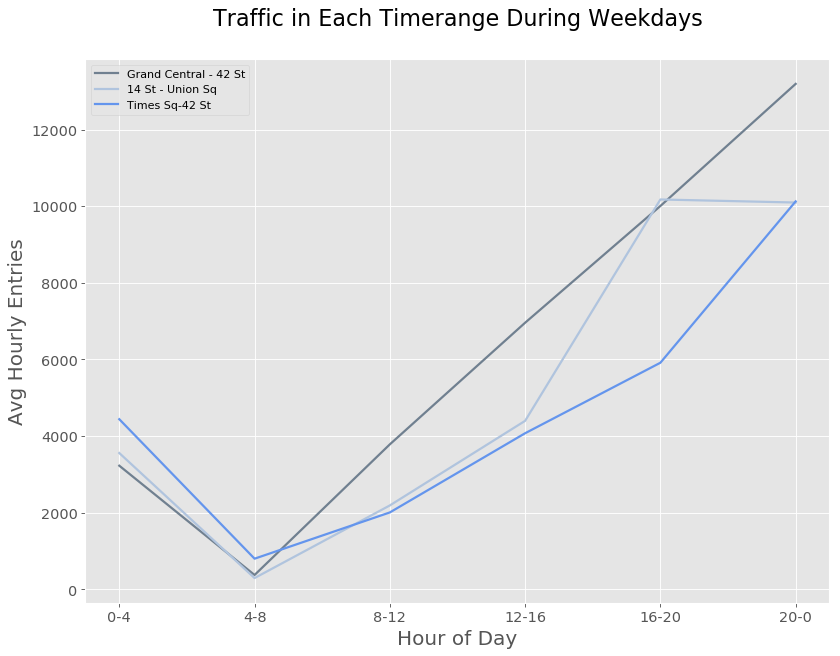

In [140]:
X = ["0-4","4-8","8-12","12-16","16-20","20-0"]  
X_axis = np.arange(len(X))
plt.style.use('ggplot')
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(X_axis, top3_TR_weekdays_pivot["GRD CNTRL-42 ST"],label = 'Grand Central - 42 St',color="slategrey",linewidth=2)
plt.plot(X_axis, top3_TR_weekdays_pivot["14 ST-UNION SQ"],label = '14 St - Union Sq',color="lightsteelblue",linewidth=2)
plt.plot(X_axis, top3_TR_weekdays_pivot["TIMES SQ-42 ST"],label = 'Times Sq-42 St',color="cornflowerblue",linewidth=2)
  
plt.xticks(X_axis, X,size=13)
plt.yticks(size=13)
plt.xlabel("Hour of Day",size=18)
plt.ylabel("Avg Hourly Entries",size=18)
plt.title("Traffic in Each Timerange During Weekdays",size=20,y=1.05)
plt.legend()
plt.savefig("HourlyTraffic_Weekdays.png", dpi=300, transparent=True)
plt.show()

#### Then look at weekends

In [142]:
top3_turnstiles_weekends=turnstiles_top3_df[turnstiles_top3_df.IF_WEEKENDS==1]
top3_hr_weekends=top3_turnstiles_weekends.groupby(["STATION","DATE","TIMERANGE"]).HOURLY_ENTRIES.sum().reset_index()

top3_hr_weekends.head()

,STATION,DATE,TIMERANGE,HOURLY_ENTRIES
0,14 ST-UNION SQ,2021-07-03,4,3755.0
1,14 ST-UNION SQ,2021-07-03,8,743.0
2,14 ST-UNION SQ,2021-07-03,12,805.0
3,14 ST-UNION SQ,2021-07-03,16,3314.0
4,14 ST-UNION SQ,2021-07-03,20,6709.0


In [143]:
top3_TR_weekends=top3_hr_weekends.groupby(["STATION","TIMERANGE"]).HOURLY_ENTRIES.mean().reset_index()

In [145]:
top3_TR_weekends_pivot=pd.pivot_table(top3_TR_weekends,values="HOURLY_ENTRIES",columns="STATION",index="TIMERANGE")

In [58]:
top3_TR_weekends_pivot

STATION,14 ST-UNION SQ,GRD CNTRL-42 ST,TIMES SQ-42 ST
TIMERANGE,,,
0-4,4325.576923,1675.192308,5821.961538
4-8,862.230769,278.519231,1550.481481
8-12,795.115385,355.538462,662.296296
12-16,3096.538462,1807.596154,2549.740741
16-20,6962.384615,2738.134615,2868.214286
20-0,6574.307692,2567.653846,4173.189189


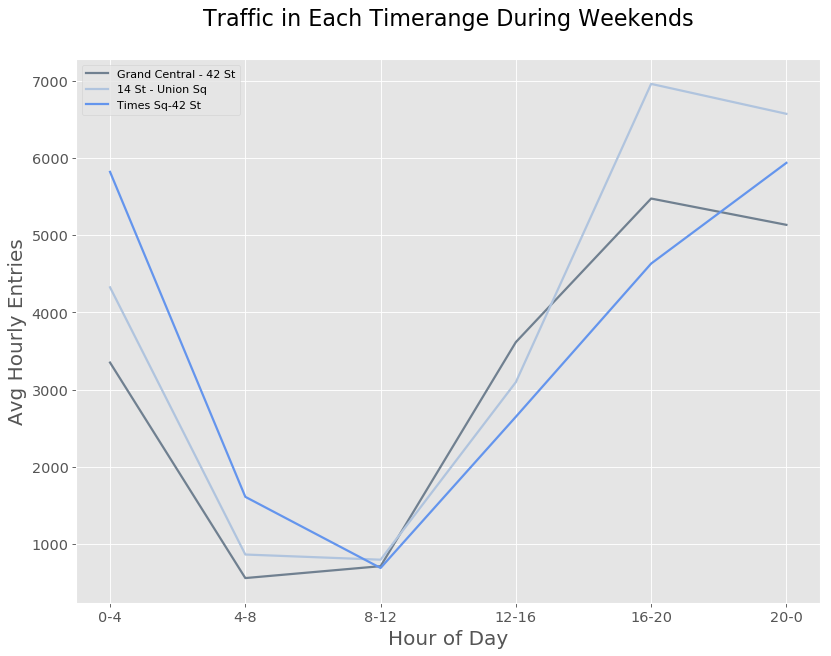

In [146]:
X = ["0-4","4-8","8-12","12-16","16-20","20-0"]  
X_axis = np.arange(len(X))
plt.style.use('ggplot')
plt.figure(figsize=(12, 9), dpi=80)
plt.plot(X_axis, top3_TR_weekends_pivot["GRD CNTRL-42 ST"],label = 'Grand Central - 42 St',color="slategrey",linewidth=2)
plt.plot(X_axis, top3_TR_weekends_pivot["14 ST-UNION SQ"],label = '14 St - Union Sq',color="lightsteelblue",linewidth=2)
plt.plot(X_axis, top3_TR_weekends_pivot["TIMES SQ-42 ST"],label = 'Times Sq-42 St',color="cornflowerblue",linewidth=2)
  
plt.xticks(X_axis, X,size=13)
plt.yticks(size=13)
plt.xlabel("Hour of Day",size=18)
plt.ylabel("Avg Hourly Entries",size=18)
plt.title("Traffic in Each Timerange During Weekends",size=20,y=1.05)
plt.legend()
plt.savefig("HourlyTraffic_Weekends.png", dpi=300, transparent=True)
plt.show()